# Многослойный перцептрон

В этом блокноте мы реализуем возможность построения полносвязной многослойной нейронной сети при помощи `numpy`. Сначала загрузим требующиеся библиотеки.

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

## Немного про то, как действуют слои

На данный момент мы намеренно не будем расширять матрицу входных данных значениями $-1$, как мы это делали в однослойной сети, и опишем действие слоя нейронной сети несколько иначе. 

Пусть нам дан на вход некоторый набор данных $X$ размера $[n \times p]$, состоящий из $n$ объектов, каждый из которых характеризуется $p$ фичами. Действие любого скрытого слоя нейронной сети можно разбить на два этапа. Первый этап — это действие сумматора, производится оно следующим образом:
$$
Y_1 = X\cdot W_0 - b_0,
$$
где $W_0$ — матрица размера $[p \times n_1]$, где $n_1$ — количество нейронов следующего слоя, $b_0$ — вектор смещений каждого нейрона (по сути — матрица размера $[n \times n_1]$, чьи элементы, находящиеся в одном столбце, одинаковы). Итого, на выходе мы получаем для каждого объекта $n_1$ новый признак. Но это не все, второй этап — применение некоторой функции активации $\varphi_0$ поэлементно ко всем элементам матрицы $Y_1$, полученной этапом ранее:
$$
Z_1 = \varphi_0(Y_1).
$$
Полученная матрица и является входной матрицей для следующего слоя нейронов. 

Таким образом, имея $(k - 1)$ построенный слой, мы можем построить $k$-ый слой при помощи двух операций:
$$
Y_k = Z_{k - 1}W_{k-1} - b_{k-1}, \quad Z_k = \varphi_{k-1}(Y_k).
$$
Последний слой обычно выделяют особо, так как этот слой — выходной, и в зависимости от решаемой задачи его выход может разниться. 

## Выходной слой при классификации

Мы, опять-таки, будем решать задачу классификации, так что введем еще раз уже известные обозначения.

Пусть
$$
x_i = (x_i^1, ..., x_i^{p}), \quad i \in \{1, 2, ..., n\},
$$
— $i$-ый тренировочный объект, $y_i$ — числовая метка класса $i$-ого объекта,
$$
w^j = (w_1^j, ..., w_{p}^j)^T, \quad j \in \{1, 2, ..., m\},
$$
— веса $j$-ого нейрона — столбцы матрицы $W$, $b^j$ — смещение $j$-ого нейрона — столбцы матрицы $b$.

Напишем интересующую нас функцию потерь, $y = \{y_1, ..., y_n\}$:
$$
Loss(X, W, y) = -\frac{1}{n} \sum\limits_{i = 1}^n \ln \frac{\exp(x_i \cdot w^{y_i} - b^{y_i})}{\sum\limits_{j = 1}^m\exp(x_i \cdot w^j - b^j)} + \lambda R(w) = -\frac{1}{n}\sum\limits_{i = 1}^n \left((x_i \cdot w^{y_i} - b^{y_i}) - \ln \sum\limits_{j = 1}^m\exp(x_i \cdot w^j - b^j)\right) + \lambda  R(w),
$$
где 
$$
x_i \cdot w^j = \sum\limits_{k = 1}^px_i^kw^j_k
$$
— скалярное произведение соответсвующих векторов.

Для обучения сети нам понадобится градиент этой функции, вычислим его.
$$
\frac{\partial Loss(X, W, y)}{\partial w^{y'}_p} = -\frac{1}{n} \sum\limits_{i = 1}^n \left( x_i^p[y_i = y'] - x_i^p \frac{exp(x_i \cdot w^{y'})}{\sum\limits_{j = 1}^m \exp(x_i \cdot w^j)}\right) + \lambda  \frac{\partial R}{\partial w}.
$$
В таком виде градиент использовать неудобно и вычислительно неэффективно. Можно заметить, что в матричном виде он переписывается следующим образом:
$$
\frac{\partial Loss(X, W, y)}{\partial w} = -\frac{1}{n}X^T\left(M - P\right) + \lambda \frac{\partial R}{\partial w}.
$$
Поясним входящие в последнее выражение объекты.  Как мы уже отметили, до применения функции активации выходы нейронов после «сумматора» для набора данных $X$ могут быть получены следущим образом:
$$
Outs = X \cdot W - b.
$$
Матрица $Outs$ имеет размер $[n \times m]$ и построчно содержит значения выходов каждого из $m$ нейронов для соответсвующего объекта подаваемых данных. Тогда матрица $P$ — это матрица `softmax`-ов для каждого нейрона, на пересечении $i$-ой строки и $t$-ого столбца которой стоят значения
$$
\frac{\exp(x_i \cdot w^t)}{\sum\limits_{j = 1}^m \exp(x_i \cdot w^j)}, \quad i \in \{1, 2, ..., n\}, \quad t \in \{1, 2, ..., m\},
$$
$M$ — матрица размера $[n \times m]$ — разреженная матрица `one_hot` кодированных откликов. 

## Снова про регуляризацию



Теперь про регуляризацию. В случае $l_p$, $p \in \{1, 2\}$, регуляризатор имеет вид:
$$
R_p(W) = \sum\limits_{i = 1}^p\sum\limits_{j = 1}^m |w_i^j|^p,
$$
поэтому в матричном виде производная (или градиент) может быть записана так:
$$
\frac{\partial R_2}{\partial w} = 2\lambda W, \quad \frac{\partial R_1}{\partial \omega} = \lambda \operatorname{sign}W.
$$

## Теперь о матричном дифференцировании

Матричные операции очень неплохо реализованы в питоне, поэтому именно им и стоит отдать предпочтение при реализации шага градиентного спуска для поиска параметров слоев. Мы уже поняли, что если выходы последнего слоя завязаны на функции потерь, описанной выше, то 
$$
\frac{\partial Loss(X, W, y)}{\partial w} = -\frac{1}{n}X^T\left(M - P\right) + \lambda \frac{\partial R}{\partial w}.
$$
Это реализовано в `__get_grad`. В общем случае,
$$
Z = \varphi(XW - b), \quad \frac{\partial Z}{\partial W} = X^T\frac{\partial(\varphi(XW - b))}{\partial(XW - b)}, \quad \frac{\partial Z}{db} = - \frac{\partial(\varphi(XW - b))}{\partial(XW - b)}.
$$
Немного деликатнее оказывается вопрос вычисления более «глубоких» производных, ведь параметры предыдущих слоев находятся внутри $X$, а $X$ получается в результате применения функции активации предыдущего слоя. Поятно, что если
$$
X = \psi(\widetilde X \widetilde W - \widetilde b),
$$
то
$$
\frac{\partial Z}{\partial \widetilde W} = \widetilde X^T\left(\left(\frac{\partial(\varphi(XW - b))}{\partial(XW - b)} W^T\right) \odot \frac{\partial \psi(X \widetilde W - \widetilde b)}{\partial (X \widetilde W - \widetilde b)}\right),
$$
и так далее. Это правило цепочки реализовано в самом конце метода `fit`.

## Программная реализация и тесты

In [153]:
class FullyConnectedNetwork:
    
    __REGULARIZATION_GRAD = {None: lambda _w: 0, "l1": lambda _w: torch.sign(_w), "l2": lambda _w: 2*_w}
    __REGULARIZATION_FUNC = {None: lambda _w: 0, "l1": lambda _w: torch.abs(_w), "l2": lambda _w: _w ** 2}
    __LOSS = 0
    
    # создание нейронной сети: alpha — скорость обучения (шаг градиентного спуска), reg_type — тип регуляризации (если есть), lambda — параметр регуляризации; слои будут храниться в списке layers
    def __init__(self, alpha=0.01, reg_type=None, lambda_=0, shpilevoi_gain=0.75):
        self.__layers = list()
        self.__alpha = alpha
        self.__reg_type = reg_type
        self.__lambda = lambda_

    # метод, позволяющий добавить новый слой: указываем правильные размеры слоя, название функции активации, class_number — количество классов в случае использования Sotmax'а на последнем слое, параметр a — параметр LeakyReLU
    def add_layer(self, size: tuple, activation_func: str, class_number=0, a=0):
        if not self.__layers or self.__layers[-1].size[1] == size[0]:
            self.__layers.append(FullyConnectedLayer(size, activation_func, class_number, a))
        else:
            raise Exception("Wrong size of the layer!")

    def change_alpha(self, alpha):
        self.__alpha = alpha

    def get_loss(self):
        return FullyConnectedNetwork.__LOSS

    def get_val_loss(self, data, answers):
        layer_outputs = [data]
        current_output = layer_outputs[0]
        # forward pass и вычисление градиентов функций активации
        for layer in self.__layers:
            current_output, _ = layer.forward(current_output, answers)

        return current_output

    # метод, выдающий предсказания для заданного набора данных после обучения модели
    def predict(self, data):
        current_output = data
        for layer in self.__layers[:-1]:
            current_output, _ = layer.forward(current_output, None)
        # отдельно обрабатываем последний слой
        layer_weights, layer_biases = self.__layers[-1].get_weights()
        current_output = current_output @ layer_weights - layer_biases
        _exp_outputs = (current_output - torch.amax(current_output)).exp()
        answ = _exp_outputs / _exp_outputs.sum(axis=1, keepdim=True)
        return torch.tensor([torch.argmax(_row) for _row in answ])

    def score(self, data, answers):
        return (self.predict(data) == answers).sum() / len(answers)

    def fit(self, data, answers, use_old_weight):
        # выход входного слоя совпадает с фичами входных данных
        layer_outputs = [data]
        current_output = layer_outputs[0]
        grads = []
        # forward pass и вычисление градиентов функций активации
        for layer in self.__layers:
            current_output, gradient = layer.forward(current_output, answers)
            layer_outputs.append(current_output)
            grads.append(gradient)
        # для вычисления градиентов по правилу цепочки, удобно развернуть массив
        grads = grads[::-1]
        # для градиента параметров самого первого слоя, умножаем на «производную» независимой переменной
        grads.append(1)
                
        current_gradient = grads[0]
        FullyConnectedNetwork.__LOSS = layer_outputs[-1]
        for i, layer in enumerate(self.__layers[::-1]):
            layer_weights, layer_biases = layer.get_weights()
            # FullyConnectedNetwork.__LOSS += self.__lambda * (np.sum(FullyConnectedNetwork.__REGULARIZATION_FUNC[self.__reg_type](layer_weights) + FullyConnectedNetwork.__REGULARIZATION_FUNC[self.__reg_type](layer_biases)))
            # вычисление градиента параметров W слоя layer
            d_weights = layer_outputs[-2 - i].T @ current_gradient
            # вычисление градиента параметров db слоя layer
            d_bias = (torch.ones(layer_outputs[-2 - i].shape[0]) @ current_gradient) / layer_outputs[-2 - i].shape[0]
            # выполнение шага градиентного спуска
            
            old_w = layer_weights.clone()
            
            layer.update_weights(self.__alpha * (d_weights + self.__lambda * FullyConnectedNetwork.__REGULARIZATION_GRAD[self.__reg_type](layer_weights)) , self.__alpha * (d_bias + self.__lambda * FullyConnectedNetwork.__REGULARIZATION_GRAD[self.__reg_type](layer_biases)))

            if use_old_weight:
                current_gradient = np.matmul(current_gradient, old_w.T) * grads[i + 1]
            else:
                current_gradient = np.matmul(current_gradient, layer_weights.T) * grads[i + 1]
                
    # метод для отрисовки весов, первый параметр должен быть квадратом целого числа
    def print_weights(self, label="No label"):
        for layer in self.__layers:
            _pixel_weights, _bias = layer.get_weights()
            size = tuple([int(round((_pixel_weights.shape[0] - 1) ** 0.5)) for _ in range(2)])
            fig, axes = plt.subplots(ncols=5, nrows=2)
            fig.set_size_inches(20, 10)
            for j in range(10):
                axes[j // 5, j % 5].imshow((_pixel_weights[:, j]).reshape(size), cmap=plt.cm.gray, label=label)

# класс, отвечающий за слой в нейронной сети
class FullyConnectedLayer:
    # мы предполагаем, что реализованы следующие функции активации, на последнем слое возможно решение задачи классификации с Softmax
    __ACTIVATION_FUNCTIONS = {'ReLU': {'func': lambda a, x: torch.maximum(x, torch.zeros_like(x)), 'derivative': lambda a, x: torch.where(x >= 0, 1, 0)},
                              'LReLU': {'func': lambda a, x: torch.where(x >= 0, x, a*x), 'derivative': lambda a, x: torch.where(x >= 0, 1, a)},
                              'None': {'func': lambda a, x: x, 'derivative': lambda a, x: 1},
                              'Sigmoid': {'func': lambda a, x: torch.exp(x) / (1 + torch.exp(x)), 'derivative': lambda a, x: torch.exp(x) / (1 + torch.exp(x)) ** 2},
                              'Softmax': {}}
    # создание нового слоя: задание размеров слоя, случайная (равномерная на [-1/2, 1/2]) инициализация весов, запоминание функции активации, фиксация количества классов в случае решения задачи классификации
    def __init__(self, size: tuple, activation_func: str, class_number=0, a=0):
        self.size = size
        torch.manual_seed(42)
        self.__weights = torch.rand((size[0], size[1])) - 0.5
        torch.manual_seed(42)
        self.__bias = torch.rand((1, size[1])) - 0.5
        self.__a = a
        if activation_func in FullyConnectedLayer.__ACTIVATION_FUNCTIONS.keys():
            self.__activation_func = activation_func
        else:
            raise Exception("No such activation function!")
        if activation_func == 'Softmax':
            self.__class_number = class_number

    # метод, возвращающий значения весов: веса и смещения
    def get_weights(self):
        return self.__weights, self.__bias

    # метод, модифицирующий веса после градиентного шага
    def update_weights(self, d_weights, d_biases):
        self.__weights -= d_weights
        self.__bias -= d_biases

    # метод, возвращающий градиент
    def __get_grad(self, data, answers):
        if self.__activation_func == 'Softmax':
            return - (self.__one_hot(answers) - self.__get_probabilities(data)) / len(answers)
        else:
            return FullyConnectedLayer.__ACTIVATION_FUNCTIONS[self.__activation_func]['derivative'](self.__a, data)

    # one-hot encoding меток класса
    def __one_hot(self, answers):
        one_hot_answers = torch.zeros((len(answers), self.__class_number))
        one_hot_answers[torch.arange(len(answers)), answers.int()] = 1
        return one_hot_answers

    # метод, возвращающий вероятности после Softmax'a
    def __get_probabilities(self, data):
        _outputs = data @ self.__weights + self.__bias
        
        _gamma = torch.amax(_outputs)
        _exp_outputs = (_outputs - _gamma).exp()
        
        _exp_outputs = (_outputs).exp()
        return (_exp_outputs.T / _exp_outputs.sum(axis=1)).T

    # проход по слою с вычислением градиента функции активации на текущей итерации и текущем наборе данных, для последнего слоя нет нужды вычислять значение, если только не хочется узнать что-то про функцию потерь
    def forward(self, data, answers):
        
        if self.__activation_func == 'Softmax':
            matrix_pass = data @ self.__weights + self.__bias
            print('classical output', matrix_pass.mean().item())
            
            #my_ce = -((matrix_pass * self.__one_hot(answers)).sum(axis=1, keepdim=True) - matrix_pass.exp().sum(axis=1, keepdim=True).log()).mean()
            ce = torch.nn.CrossEntropyLoss()
            activation = ce(matrix_pass, answers.long())
            gradient = self.__get_grad(data, answers)
            
        else:
            matrix_pass = data @ self.__weights - self.__bias
            activation = FullyConnectedLayer.__ACTIVATION_FUNCTIONS[self.__activation_func]['func'](self.__a, matrix_pass)
            gradient = self.__get_grad(matrix_pass, answers)
        
        return activation, gradient

In [85]:
data = pd.read_csv("archive/fashion-mnist_train.csv")

X = torch.from_numpy(data[data.columns[1:]].values).float()
Y = torch.from_numpy(data[data.columns[0]].values).float()

In [86]:
test_data = pd.read_csv("archive/fashion-mnist_test.csv")

test_x = torch.from_numpy(test_data[test_data.columns[1:]].values).float()
test_y = torch.from_numpy(test_data[test_data.columns[0]].values).float()

test_x = test_x / 255

In [87]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)
X_train_small = X_train_small / 255
X_test_small = X_test_small / 255

In [88]:
def get_batches(x, y, batch_size):
    
    for i in range(0, len(x), batch_size):
        yield x[i:i + batch_size], y[i:i + batch_size]

batch_size = 1024

In [167]:
import torch

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()
        torch.manual_seed(0)
        self.relu = torch.nn.ReLU()
        self.linear1 = torch.nn.Linear(784, 784)
        self.linear2 = torch.nn.Linear(784, 256)
        self.linear3 = torch.nn.Linear(256, 128)
        self.linear4 = torch.nn.Linear(128, 10)

    def forward(self, x):
        # print(f'{x[0].mean()=}')
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        # print(f'{x[0].mean()=}')
        # x = self.activation(x)
        return x
        
tinymodel = TinyModel()
init_weight1 = deepcopy(tinymodel.linear1.weight.detach())
init_bias1 = deepcopy(tinymodel.linear1.bias.detach())

init_weight2 = deepcopy(tinymodel.linear2.weight.detach())
init_bias2 = deepcopy(tinymodel.linear2.bias.detach())


init_weight3 = deepcopy(tinymodel.linear3.weight.detach())
init_bias3 = deepcopy(tinymodel.linear3.bias.detach())


init_weight4 = deepcopy(tinymodel.linear4.weight.detach())
init_bias4 = deepcopy(tinymodel.linear4.bias.detach())

optimizer = torch.optim.SGD(tinymodel.parameters(), lr=0.01, weight_decay=0.0007)
loss_fn = torch.nn.CrossEntropyLoss()
l = []
means = []

def train(l, m):
    for ep in range(100):
        print('ep', ep)
        print('---------------------')
        for x_batch, y_batch in get_batches(X_test_small, y_test_small, batch_size):
            optimizer.zero_grad()
            # Make predictions for this batch
            outputs = tinymodel(x_batch)
            # Compute the loss and its gradients
            loss = loss_fn(outputs, y_batch.long())
            print(f'{outputs.mean().item()=}')
            m.append(outputs.mean().item())
            
            
            loss.backward()
            #print('grad', tinymodel.linear1.weight.grad[0].mean())
            # Adjust learning weights
            print(f'{loss.mean()=}')
            optimizer.step()
        loss = loss_fn(outputs, y_batch.long())
        l.append(loss.item())
        print(f'{(loss.item())=}')
train(l, means)

ep 0
---------------------
outputs.mean().item()=0.002182572614401579
loss.mean()=tensor(2.3081, grad_fn=<MeanBackward0>)
outputs.mean().item()=0.0021149194799363613
loss.mean()=tensor(2.3059, grad_fn=<MeanBackward0>)
outputs.mean().item()=0.0020893639884889126
loss.mean()=tensor(2.3061, grad_fn=<MeanBackward0>)
outputs.mean().item()=0.0022594064939767122
loss.mean()=tensor(2.3063, grad_fn=<MeanBackward0>)
outputs.mean().item()=0.0020848079584538937
loss.mean()=tensor(2.3030, grad_fn=<MeanBackward0>)
outputs.mean().item()=0.0020900170784443617
loss.mean()=tensor(2.3010, grad_fn=<MeanBackward0>)
outputs.mean().item()=0.0019639625679701567
loss.mean()=tensor(2.2991, grad_fn=<MeanBackward0>)
outputs.mean().item()=0.0020908694714307785
loss.mean()=tensor(2.3015, grad_fn=<MeanBackward0>)
outputs.mean().item()=0.001938970759510994
loss.mean()=tensor(2.3030, grad_fn=<MeanBackward0>)
outputs.mean().item()=0.0018932728562504053
loss.mean()=tensor(2.3025, grad_fn=<MeanBackward0>)
outputs.mean().

In [168]:
def train(model, num_ep=400, use_old_weight=True, init_lr=0.025, decay_sched=None):
    
    loss_tr = []
    loss_val = []

    acc_tr = []
    acc_val = []

    for ep in range(num_ep):
        print('ep', ep)
        print('---------------------')
        for i, batch in enumerate(get_batches(X_test_small, y_test_small, batch_size)):
            x_batch, y_batch = batch
            model.fit(x_batch, y_batch, use_old_weight)
            
        loss_tr.append(model.get_loss())
        print(loss_tr[-1].item())
        # loss_val.append(model.get_val_loss(X_test_small, y_test_small))
        # acc_tr.append(model.score(X_train_small, y_train_small))
        # acc_val.append(model.score(X_test_small, y_test_small))
        # print('ep: ', ep, 'Training accuracy: ', acc_tr[-1], 'Test accuracy:', acc_val[-1], 'Train loss:', loss_tr[-1], 'Val loss:', loss_val[-1],)
        
        if (decay_sched != None) and (ep in decay_sched):
            alpha = decay_sched[ep]
            model.change_alpha(alpha)
            
    return loss_tr, loss_val, acc_tr, acc_val

In [169]:
from copy import deepcopy
NN = FullyConnectedNetwork(alpha=0.01, reg_type='l2', lambda_=0.0007)

NN.add_layer((784, 784), 'ReLU')
NN.add_layer((784, 256), 'ReLU')
NN.add_layer((256, 128), 'ReLU')
NN.add_layer((128, 10), 'Softmax', class_number=10)

NN.__dict__['_FullyConnectedNetwork__layers'][0].__dict__['_FullyConnectedLayer__weights'] = init_weight1.T
NN.__dict__['_FullyConnectedNetwork__layers'][0].__dict__['_FullyConnectedLayer__bias'] = init_bias1


NN.__dict__['_FullyConnectedNetwork__layers'][1].__dict__['_FullyConnectedLayer__weights'] = init_weight2.T
NN.__dict__['_FullyConnectedNetwork__layers'][1].__dict__['_FullyConnectedLayer__bias'] = init_bias2


NN.__dict__['_FullyConnectedNetwork__layers'][2].__dict__['_FullyConnectedLayer__weights'] = init_weight3.T
NN.__dict__['_FullyConnectedNetwork__layers'][2].__dict__['_FullyConnectedLayer__bias'] = init_bias3


NN.__dict__['_FullyConnectedNetwork__layers'][3].__dict__['_FullyConnectedLayer__weights'] = init_weight4.T
NN.__dict__['_FullyConnectedNetwork__layers'][3].__dict__['_FullyConnectedLayer__bias'] = init_bias4

loss_tr, loss_val, acc_tr, acc_val = train(NN, 100, use_old_weight=True, decay_sched={1000: 0.002})

ep 0
---------------------
classical output 0.003540846286341548
classical output 0.0036507253535091877
classical output 0.0035804682411253452
classical output 0.0036925661843270063
classical output 0.003603277262300253
classical output 0.0038026180118322372
classical output 0.003827861975878477
classical output 0.003803583327680826
classical output 0.0036657308228313923
classical output 0.003767918096855283
classical output 0.0037139025516808033
classical output 0.0037181975785642862
2.303987979888916
ep 1
---------------------
classical output 0.0037004705518484116
classical output 0.003797060577198863
classical output 0.0037432133685797453
classical output 0.0038630228955298662
classical output 0.003759498242288828
classical output 0.003966012038290501
classical output 0.003994374070316553
classical output 0.003962283488363028
classical output 0.0038310338277369738
classical output 0.003929511643946171
classical output 0.0038844365626573563
classical output 0.003876008093357086
2.30

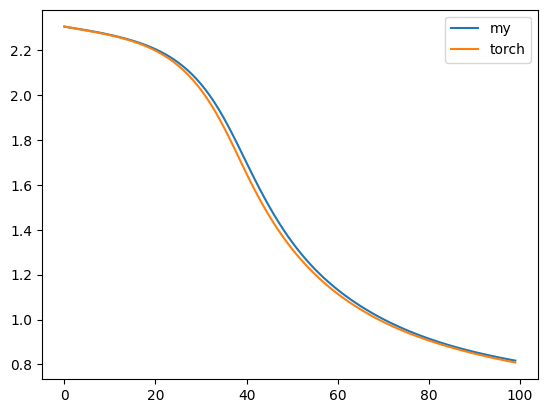

In [171]:
plt.plot(loss_tr, label='my')
plt.plot(l, label='torch')
plt.legend()

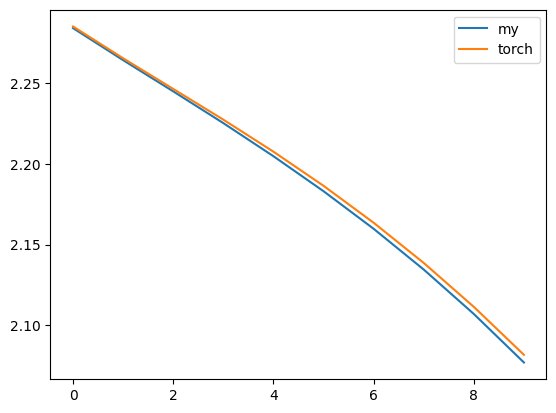

In [155]:
plt.plot(loss_tr, label='my')
plt.plot(l, label='torch')
plt.legend()

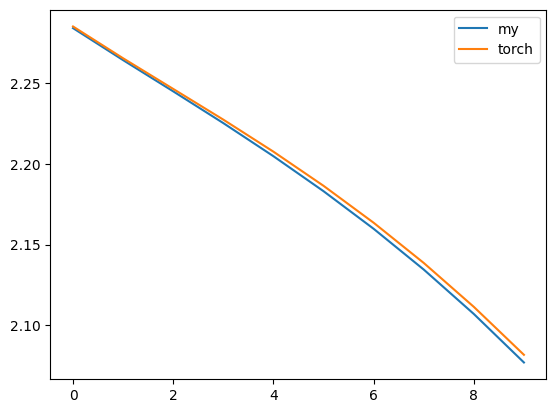

In [146]:
plt.plot(loss_tr, label='my')
plt.plot(l, label='torch')
plt.legend()

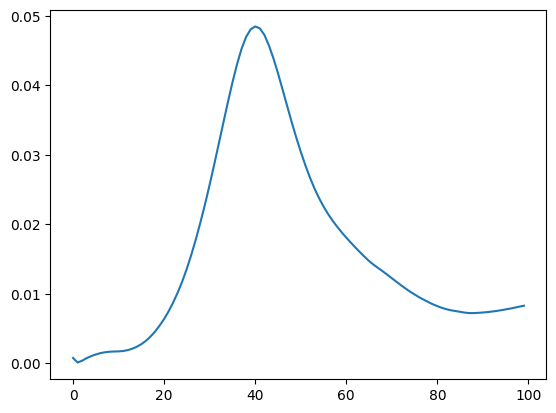

In [172]:
plt.plot(np.abs(np.array(l) - np.array(list(map(lambda x: x.item(), loss_tr)))))

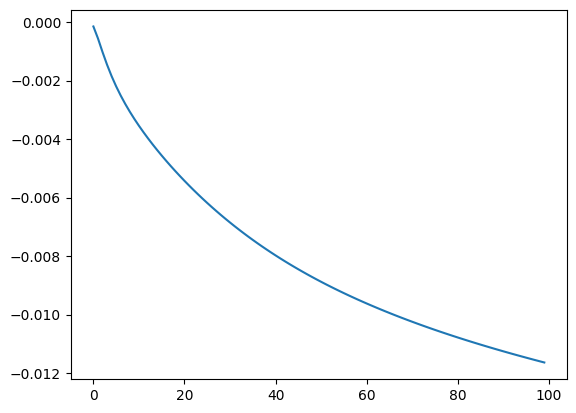

In [120]:
plt.plot(np.array(l) - np.array(list(map(lambda x: x.item(), loss_tr))))